In [1]:
from datetime import datetime
from math import ceil
import numpy as np
import pandas as pd

In [2]:
pd.options.display.max_columns = None

# Meta Features

Here I extract meta features from the anonymised the synethic dataset (see `Anonymisation.ipynb`). This notebook demonstrates the techniques on a sample of the dataset. I have not made a file which applies all of these methods at once as it is likely some features won't be used and other will want to be tweaked.

## TOC
 * [Time](#Time)
   * [Hour of Day](#hr_of_day)
 * [Currency Conversion](#Currency-Conversion)
 * [Transcations per Entity](#Transcations-per-Entity)
 * [Time Since Last Transaction](#Time-Since-Last-Transaction)
 * [Transaction Value Statistics by Entity](#Transaction-Value-Statistics-by-Entity)
 * [Number of Transaction on Day by Entity](#Number-of-Transaction-on-Day-by-Entity)

In [3]:
# Load the data
clean_data=pd.read_csv("data/cleaned_synthetic_data.csv",index_col=0)

sample_df=clean_data.sample(n=10)
prepared_df=sample_df.copy()

c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
sample_df.head(5)

,is_fraud,unix_time,amt,cc_id,person_id,gender_id,job_category,age,city_pop_cluster_id,merchant_id,merchant_category
212201,0,1334761870,52.94,654,782,0,-1,35,72,164,home
773228,0,1353986387,3.56,185,366,1,102,57,38,33,shopping_pos
39973,0,1327403797,2.49,391,654,0,351,54,6,179,shopping_pos
1289971,0,1371580639,22.72,904,452,0,373,31,71,422,personal_care
634123,0,1348721539,2.51,411,628,0,-1,43,78,281,misc_net


## Time

In the real data set time is given in seconds since the first transaction. I implement the function `standardise_time` which calculates the number of seconds between mid-night on the day of the first transaction and each transaction.

In [5]:
def standardise_time(series) -> pd.Series:
    min_time=datetime.utcfromtimestamp(series.min())
    min_day=min_time.replace(second=0,minute=0,hour=0)
    return ((series-min_day.timestamp())).astype(int)

In [6]:
prepared_df["seconds_from_start"]=standardise_time(sample_df["unix_time"])

In [7]:
prepared_df.head(10)

,is_fraud,unix_time,amt,cc_id,person_id,gender_id,job_category,age,city_pop_cluster_id,merchant_id,merchant_category,seconds_from_start
212201,0,1334761870,52.94,654,782,0,-1,35,72,164,home,7398670
773228,0,1353986387,3.56,185,366,1,102,57,38,33,shopping_pos,26623187
39973,0,1327403797,2.49,391,654,0,351,54,6,179,shopping_pos,40597
1289971,0,1371580639,22.72,904,452,0,373,31,71,422,personal_care,44217439
634123,0,1348721539,2.51,411,628,0,-1,43,78,281,misc_net,21358339
457039,0,1342880464,73.54,710,486,1,-1,32,77,204,health_fitness,15517264
41144,0,1327483466,83.74,975,153,1,-1,31,17,543,grocery_pos,120266
1174413,0,1367730727,5.21,684,852,1,-1,52,74,198,shopping_net,40367527
1112127,0,1365339686,81.49,896,749,0,351,56,50,515,health_fitness,37976486
222320,0,1335101381,127.97,367,503,1,-1,51,72,95,home,7738181


<a id="hr_of_day"></a>
**Hour of Day**

In [8]:
prepared_df["hour_of_day"]=pd.to_datetime(sample_df["unix_time"],unit="s").dt.hour

## Currency Conversion
All `amt` values are in dollars, but the real data we have is from Europe so we need to account for the exchange rate. The functions below allow for the conversion between any currency.

In [9]:
# !pip install forex-python
import forex_python.converter as fx

In [10]:
def convert_currency(amount:float,date:datetime,cur_currency:str,tar_currency) -> float:
    """
    Determine the value of an amount of one currency in another currency at a specified point in time
    
    PARAMETERS
    amount (float) - amount of current currency
    date (datetime) - date of exchange rate to use
    cur_currency (str) - three character code for current currency
    tar_currency (str) - three character code for target currency
    
    RETURNS
    float - amount of target currency
    """
    exchange_rate=fx.get_rate(cur_currency,tar_currency,date)
    return round(amount*exchange_rate,2)

In [11]:
def prepare_amount(df,cur_label,cur_currency="USD",tar_currency="GBP") -> pd.Series:
    """
    Convert amounts in a dataframe between currencies, using the exchange rate at the start of the date on which transaction occurred
    NOTE - conversion rate taken at start of day for speed.
    
    PARAMETERS
    df (pd.Dataframe) - dataframe of transactions with at least ["data",cur_label] columns
    cur_label (str) - name of column which contains amounts to convert
    """
    df_local=df.copy(deep=True)
    df_local["date"]=pd.to_datetime(df["unix_time"],unit="s").dt.date
    
    # determine the exchange rate for each day
    exchange_rates=pd.DataFrame()
    exchange_rates["date"]=pd.to_datetime(df_local["date"].unique(),format="%Y-%m-%d")
    exchange_rates["rate"]=exchange_rates.apply(lambda x:convert_currency(1,x["date"],cur_currency,tar_currency),axis=1)
    
    # merge dataframes
    exchange_rates["date"]=exchange_rates["date"].dt.date
    df_merged=df_local[["date","amt"]].reset_index().merge(exchange_rates[["date","rate"]],on="date",how="left").set_index('index')

    # calculated exchanged amounts
    tar_label="amount_{}".format(tar_currency)
    df_merged[tar_label]=df_merged.apply(lambda x:round(x["amt"]*x["rate"],2),axis=1)

    return df_merged[tar_label]

In [12]:
prepared_df["amount_USD"]=sample_df["amt"].copy()
prepared_df["amount_GBP"]=prepare_amount(sample_df[["unix_time","amt"]],"amt","USD","GBP")

In [13]:
prepared_df.head(5)

,is_fraud,unix_time,amt,cc_id,person_id,gender_id,job_category,age,city_pop_cluster_id,merchant_id,merchant_category,seconds_from_start,hour_of_day,amount_USD,amount_GBP
212201,0,1334761870,52.94,654,782,0,-1,35,72,164,home,7398670,15,52.94,33.35
773228,0,1353986387,3.56,185,366,1,102,57,38,33,shopping_pos,26623187,3,3.56,2.21
39973,0,1327403797,2.49,391,654,0,351,54,6,179,shopping_pos,40597,11,2.49,1.59
1289971,0,1371580639,22.72,904,452,0,373,31,71,422,personal_care,44217439,18,22.72,14.54
634123,0,1348721539,2.51,411,628,0,-1,43,78,281,misc_net,21358339,4,2.51,1.56


## Transcations per Entity

In [14]:
# Total number of transactions performed by each entity (person or merchant) in the dataset
def transactions_per_entity(ids) -> pd.Series:
    """ids - series of either `person_id` or `merchant_id`"""
    pp_trans=ids.value_counts()
    return ids.apply(lambda x: pp_trans[x])

prepared_df["transaction_by_person"]=transactions_per_entity(sample_df["person_id"])
prepared_df["transaction_by_merchant"]=transactions_per_entity(sample_df["merchant_id"])

## Time Since Last Transaction

In [15]:
# time since last transaction (merchant and customer)
def time_since_last_transaction(id_col,df) -> pd.Series:
    """
    id_col (str) - name of column which contain ids to group by
    df (pd.DataFrame) - dataframe containing `unix_time` and `id_col`
       NOTE -1 = first transaction on record
    """
    times=df[id_col].copy(deep=True)
    
    clean_data["time_since_last_transaction_person"]=-1
    for id_code in df[id_col].unique():
        trans_times=df[df[id_col]==id_code]["unix_time"]
        times.loc[df[id_col]==id_code]=trans_times.diff()

    return times.replace(np.nan,-1).astype(int)

In [16]:
# clean_data["time_since_last_transaction_person"]=time_since_last_transaction("person_id",clean_data[["person_id","unix_time"]])
# clean_data["time_since_last_transaction_merchant"]=time_since_last_transaction("merchant_id",clean_data[["merchant_id","unix_time"]])

prepared_df["time_since_last_transaction_person"]=time_since_last_transaction("person_id",sample_df[["person_id","unix_time"]])
prepared_df["time_since_last_transaction_merchant"]=time_since_last_transaction("merchant_id",sample_df[["merchant_id","unix_time"]])

## Transaction Value Statistics by Entity

In [17]:
# mean/min/max amt per merchant/customer
# NOTE this is USD val so maybe change
def entity_amount_statistic(id_col,df,agg_calc) -> pd.Series:
    
    group_by=df[[id_col,"amt"]].groupby([id_col])
    vals=group_by["amt"].agg(agg_calc)
    return df[id_col].transform(lambda x:vals[x])

prepared_df["mean_amt_person"] =entity_amount_statistic("person_id",sample_df[["person_id","amt"]],"mean")
prepared_df["max_amt_merchant"]=entity_amount_statistic("merchant_id",sample_df[["merchant_id","amt"]],"max")

## Transaction Value Statistics by Entity by Day

In [18]:
# mean/min/max amt per merchant/customer
# NOTE this is USD val so maybe change
def entity_amount_statistic_by_day(id_col,df,agg_calc) -> pd.Series:
    
    print("*",end="")
    df_copy=df[[id_col,"amt","unix_time"]].copy()
    df_copy["date"]=pd.to_datetime(df_copy["unix_time"],unit="s").dt.date
    
    print("*",end="")
    group_by=df_copy.groupby([id_col,"date"],as_index=False)
    vals=group_by["amt"].agg(agg_calc)
    
    print("*",end="")
    df_copy=df_copy.reset_index().merge(vals,on=[id_col,"date"],how='inner',suffixes=("_orig","_group_by")).set_index("index")
    print("*")
    
    col=df_copy["amt_group_by"]
    col=col[col.index.duplicated()]
    
    return col

prepared_df["mean_amt_merchant_on_day"]=entity_amount_statistic_by_day("merchant_id",sample_df[["merchant_id","amt","unix_time"]],"mean")
prepared_df["max_amt_person_on_day"]   =entity_amount_statistic_by_day("person_id",sample_df[["person_id","amt","unix_time"]],"max")
prepared_df["mean_amt_person_on_day"]  =entity_amount_statistic_by_day("person_id",sample_df[["person_id","amt","unix_time"]],"mean")

****
****
****


## Number of Transaction on Day by Entity

In [19]:
# Number of Transactions done on same say by Entity
def transaction_on_date(id_col,df) -> pd.Series:
    
    df_copy=df[[id_col,"unix_time"]].copy()
    df_copy["date"]=pd.to_datetime(df_copy["unix_time"],unit="s").dt.date
    
    group_by=df_copy[[id_col,"date"]].groupby([id_col,"date"],as_index=False)
    counts=group_by.size()
    
    df_copy=df_copy.reset_index().merge(counts,on=[id_col,"date"],how='inner',suffixes=("_orig","_group_by")).set_index("index")
    
    col=df_copy["size"]
    col=col[col.index.duplicated()]
    
    return col
    
prepared_df["transactions_on_day_person"]=transaction_on_date("person_id",sample_df[["person_id","unix_time"]])

## Save File

In [20]:
prepared_df

,is_fraud,unix_time,amt,cc_id,person_id,gender_id,job_category,age,city_pop_cluster_id,merchant_id,merchant_category,seconds_from_start,hour_of_day,amount_USD,amount_GBP,transaction_by_person,transaction_by_merchant,time_since_last_transaction_person,time_since_last_transaction_merchant,mean_amt_person,max_amt_merchant,mean_amt_merchant_on_day,max_amt_person_on_day,mean_amt_person_on_day,transactions_on_day_person
212201,0,1334761870,52.94,654,782,0,-1,35,72,164,home,7398670,15,52.94,33.35,1,1,-1,-1,52.94,52.94,NaN,NaN,NaN,NaN
773228,0,1353986387,3.56,185,366,1,102,57,38,33,shopping_pos,26623187,3,3.56,2.21,1,1,-1,-1,3.56,3.56,NaN,NaN,NaN,NaN
39973,0,1327403797,2.49,391,654,0,351,54,6,179,shopping_pos,40597,11,2.49,1.59,1,1,-1,-1,2.49,2.49,NaN,NaN,NaN,NaN
1289971,0,1371580639,22.72,904,452,0,373,31,71,422,personal_care,44217439,18,22.72,14.54,1,1,-1,-1,22.72,22.72,NaN,NaN,NaN,NaN
634123,0,1348721539,2.51,411,628,0,-1,43,78,281,misc_net,21358339,4,2.51,1.56,1,1,-1,-1,2.51,2.51,NaN,NaN,NaN,NaN
457039,0,1342880464,73.54,710,486,1,-1,32,77,204,health_fitness,15517264,14,73.54,47.07,1,1,-1,-1,73.54,73.54,NaN,NaN,NaN,NaN
41144,0,1327483466,83.74,975,153,1,-1,31,17,543,grocery_pos,120266,9,83.74,53.59,1,1,-1,-1,83.74,83.74,NaN,NaN,NaN,NaN
1174413,0,1367730727,5.21,684,852,1,-1,52,74,198,shopping_net,40367527,5,5.21,3.33,1,1,-1,-1,5.21,5.21,NaN,NaN,NaN,NaN
1112127,0,1365339686,81.49,896,749,0,351,56,50,515,health_fitness,37976486,13,81.49,53.78,1,1,-1,-1,81.49,81.49,NaN,NaN,NaN,NaN
222320,0,1335101381,127.97,367,503,1,-1,51,72,95,home,7738181,13,127.97,79.34,1,1,-1,-1,127.97,127.97,NaN,NaN,NaN,NaN


In [21]:
def save_data(df:pd.DataFrame,file_path):
    df.to_csv(file_path)

## Correlations

In [22]:
# Perform on full dataset
full_prepared_df=clean_data.copy()

In [23]:
full_prepared_df["seconds_from_start"]=standardise_time(clean_data["unix_time"])
full_prepared_df["hour_of_day"]=pd.to_datetime(clean_data["unix_time"],unit="s").dt.hour

full_prepared_df["transaction_by_person"]  =transactions_per_entity(clean_data["person_id"])
full_prepared_df["transaction_by_merchant"]=transactions_per_entity(clean_data["merchant_id"])

full_prepared_df["time_since_last_transaction_person"]  =time_since_last_transaction("person_id",clean_data[["person_id","unix_time"]])
full_prepared_df["time_since_last_transaction_merchant"]=time_since_last_transaction("merchant_id",clean_data[["merchant_id","unix_time"]])

full_prepared_df["mean_amt_person"]  =entity_amount_statistic("person_id",clean_data[["person_id","amt"]],"mean")
full_prepared_df["max_amt_person"]   =entity_amount_statistic("person_id",clean_data[["person_id","amt"]],"max")
full_prepared_df["mean_amt_merchant"]=entity_amount_statistic("merchant_id",clean_data[["merchant_id","amt"]],"mean")
full_prepared_df["max_amt_merchant"] =entity_amount_statistic("merchant_id",clean_data[["merchant_id","amt"]],"max")

full_prepared_df["mean_amt_person_on_day"]  =entity_amount_statistic_by_day("person_id",clean_data[["person_id","amt","unix_time"]],"mean")
full_prepared_df["max_amt_person_on_day"]   =entity_amount_statistic_by_day("person_id",clean_data[["person_id","amt","unix_time"]],"max")
full_prepared_df["mean_amt_merchant_on_day"]=entity_amount_statistic_by_day("merchant_id",clean_data[["merchant_id","amt","unix_time"]],"mean")
full_prepared_df["max_amt_merchant_on_day"] =entity_amount_statistic_by_day("merchant_id",clean_data[["merchant_id","amt","unix_time"]],"max")

full_prepared_df["transactions_on_day_person"]  =transaction_on_date("person_id",clean_data[["person_id","unix_time"]])
full_prepared_df["transactions_on_day_merchant"]=transaction_on_date("merchant_id",clean_data[["merchant_id","unix_time"]])

****
****
****
****


In [24]:
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 200

<AxesSubplot:title={'center':'Correlation of Numeric Features'}>

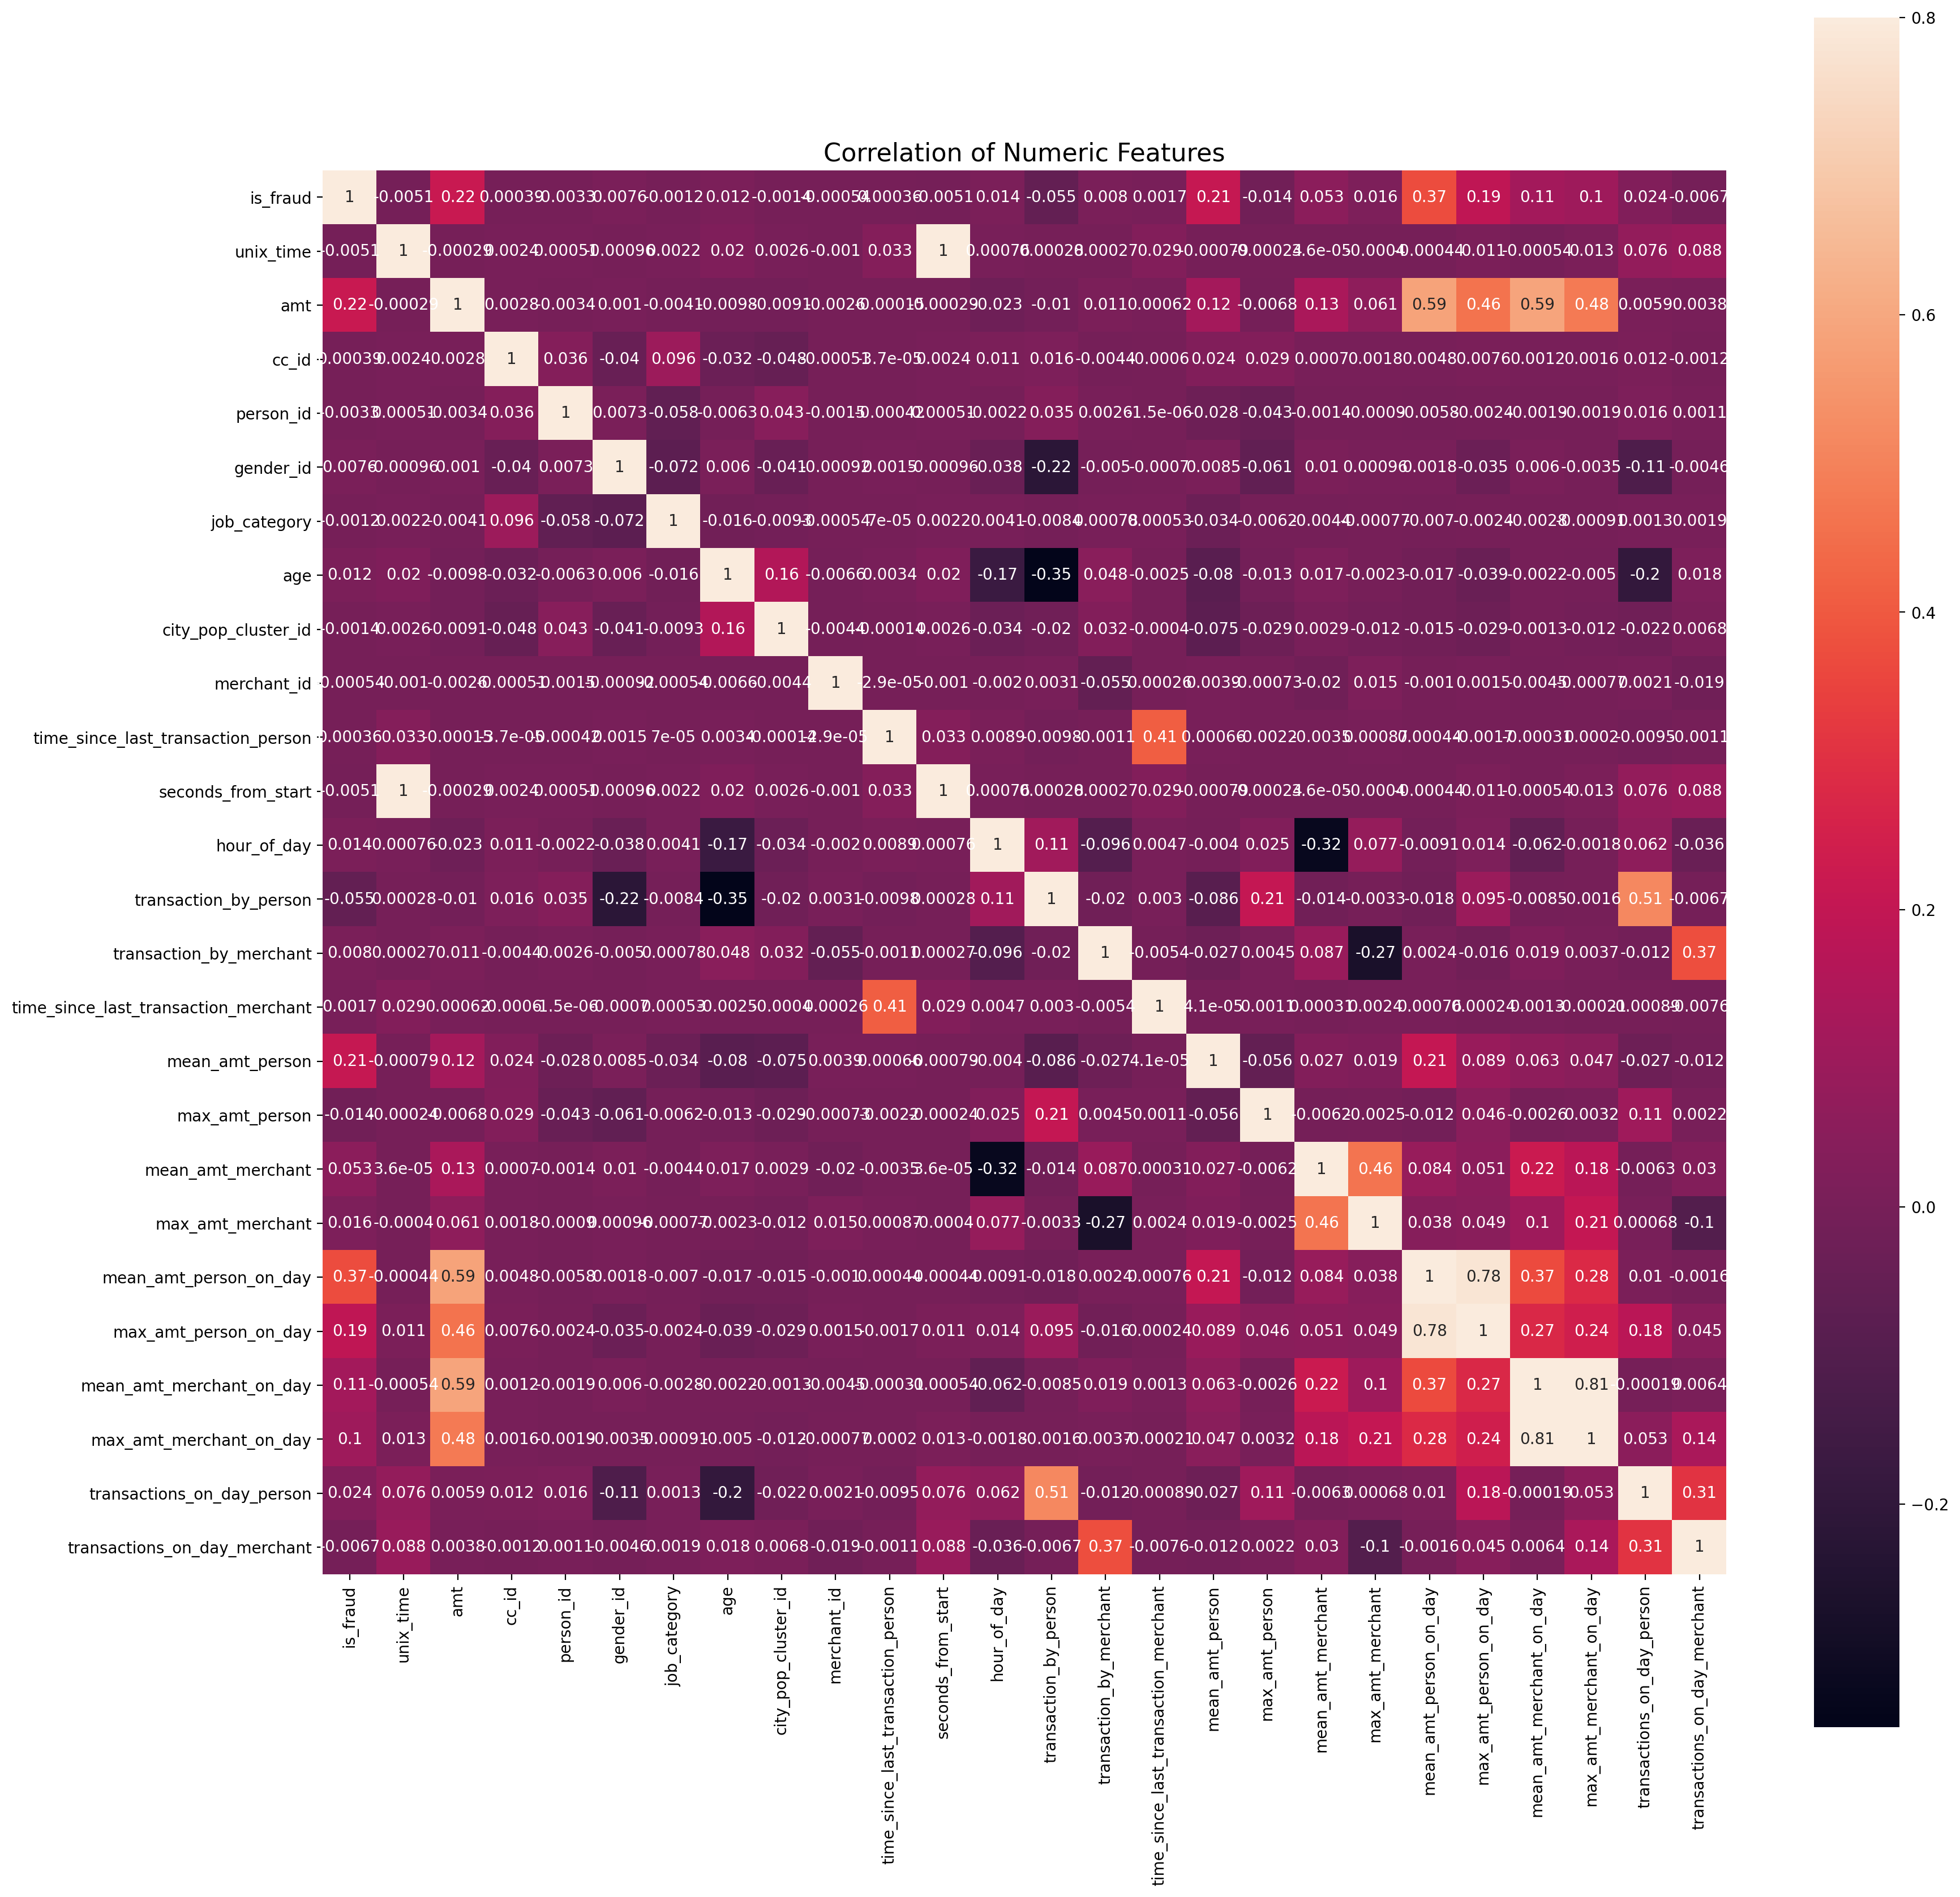

In [25]:
# RobustScaler is less prone to outliers.
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

# Split dataset for further processing
numeric_features = full_prepared_df.select_dtypes(include=[np.number])

for column in numeric_features.columns:
    numeric_features[column] = rob_scaler.fit_transform(numeric_features[column].values.reshape(-1,1))
    
fraud = numeric_features[numeric_features['is_fraud']==1]
normal = numeric_features[numeric_features['is_fraud']==0][:9651]
    
df = numeric_features.sample(frac=1)
normal_distributed_df = pd.concat([fraud, normal])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()
    
f , ax = plt.subplots(figsize = (20,20))
plt.title('Correlation of Numeric Features',y=1,size=16)
sns.heatmap(numeric_features.corr(),square = True,  vmax=0.8, annot=True)

Very few of the meta-features show strong correlations with `is_fraud`. The strongest correlation is from `mean_amt_person_on_day` (0.37). Notable, but weaker, correlations occur with `amt` (0.22), `mean_amt_person` (0.21) and `max_amt_merchant_on_day` (0.19).

(array([0.5]), [Text(0, 0.5, 'is_fraud')])

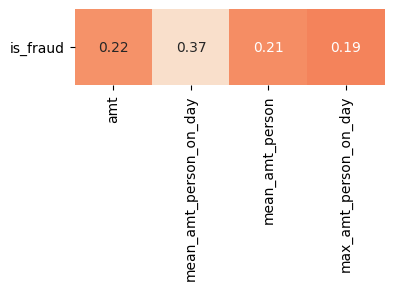

In [28]:
new_features_labels=["amt","mean_amt_person_on_day","mean_amt_person","max_amt_person_on_day"]
f , ax = plt.subplots(figsize = (4,1),dpi=100)
sns.heatmap(numeric_features.corr().loc[["is_fraud"],new_features_labels],vmax=0.4,vmin=-0.4,annot=True,cbar=False,ax=ax)
plt.yticks(rotation=0)